In [1]:
import numpy as np
from copy import deepcopy
from matplotlib import pyplot as plt
import cv2 
import os

In [2]:
class PCA:
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.components = None
        self.covariance_matrix = None
        self.mean = None
        self.sd = None

    def normalization(self,image):
        temp = deepcopy(image)
        mean = temp.mean(axis=0)
        sd= temp.std(axis=0)
        for row in range(len(temp)):
            for column in range(len(temp[row])):
                value = temp[row][column]
                value = (value-mean[column])/sd[column]
                temp[row][column]= value
        self.mean= mean
        self.sd = sd
        return temp
    
    def calc_covariance(self,vector1,vector2) :
        vec1 = deepcopy(vector1)
        vec2 = deepcopy(vector2)
        vec1_mean = vec1.mean()
        vec2_mean = vec2.mean()
        vec1 = vec1-vec1_mean
        vec2 = vec2-vec2_mean
        vec2 = vec2.T
        return (np.dot(vec1,vec2)/len(vec1))

    def covariance(self,image):
        temp = deepcopy(image)
        covariance_matrix= np.zeros((len(image[0]),len(image[0])))
        temp =temp.T
        for component1 in range(len(temp)):
            for component2 in range(len(temp)):
                variance =self.calc_covariance(temp[component1],temp[component2])
                covariance_matrix[component1][component2]= variance
        return covariance_matrix

    def calc_eign(self,matrix):
        eigen_values,eigen_vectors = np.linalg.eig(matrix)
        return eigen_values,eigen_vectors


    def fit(self,image):
        normalized_img = self.normalization(image)
        covariance_matrix = self.covariance(normalized_img)
        self.covariance_matrix = covariance_matrix

        eigen_values,eigen_vectors = self.calc_eign(covariance_matrix)   
        indecis = np.argsort(eigen_values)[::-1]
        self.components= eigen_vectors[indecis[:self.n_components]]
        print(self.components.shape)    
    def transform(self,image):
        new_image = np.dot(image,self.components.T)
        return new_image
    
    def reverse(self,image):
        revers = np.linalg.pinv(self.components)
        return np.dot(image,revers.T)


In [3]:
class Flatten():
    def __init__(self,):
        self.img_hight=0
        self.img_width= 0
    def flatten(self,images):
        self.shape= np.array(images).shape
        new_imgs = []
        for image_num in range(len(images)):
            new_imgs.append([])
            for row_n,row in enumerate(images[image_num]):
                if image_num==0:
                    self.img_hight+=1
                for column in row:
                    # for rgb_channel in range(3):
                    if row_n==0:     
                        self.img_width+=1
                        # self.rgb_channel_length+=1
                    new_imgs[image_num].extend([column[0],column[1],column[2]])
        # self.rgb_channel_length = (self.rgb_channel_length/len(new_imgs))/3
        self.img_width=(self.img_width/len(new_imgs))
        return np.array(new_imgs)
    
    def deflatten(self, imgs):
        new_imgs = []
        for img_num in range(len(imgs)):
            rgb_img = []
            for h in range(self.img_hight):
                row = []
                for w in range(int(self.img_width)):
                    i = (h * int(self.img_width) + w) * 3
                    # Reconstruct the RGB pixel from three consecutive values in the flattened array
                    pixel = [imgs[img_num][i], imgs[img_num][i + 1], imgs[img_num][i + 2]]
                    row.append(pixel)
                rgb_img.append(row)
            new_imgs.append(rgb_img)
        return np.array(new_imgs)


In [4]:
def readimage(path):
        img =cv2.imread(path)
        img = cv2.resize(img,(15,15))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        return img

In [67]:
def plot_images(images,type= " "):

    num_images = len(images)
    grid_size = int(num_images ** 0.5) + 1 

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    axes = axes.flatten()

    for i, image in enumerate(images):
        if type != "gray":
            axes[i].imshow(image)
        else:
            temp = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            axes[i].imshow(temp, cmap='gray')
        axes[i].axis('off')
        

    for ax in axes[num_images:]:
        ax.axis('off')

    plt.tight_layout()  
    plt.show()



In [68]:
pathes =os.listdir('data')
# print(pathes)
images = np.array([readimage(os.path.join("data",img)) for img in pathes])

flatten = Flatten()
flat_imgs = flatten.flatten(images)
# print(flatten.img_hight)
# new_imgs= flatten.deflatten(flat_imgs)
# flat_imgs.shape

In [69]:
flatten.deflatten(flat_imgs).shape

(6, 15, 15, 3)

In [61]:
pca = PCA(n_components=620)
pca.fit(flat_imgs)

(620, 675)


C:\Users\Magdi (Studying)\AppData\Local\Temp\ipykernel_34592\3525887667.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  pca_img_uint8 = pca_imgs.astype(np.uint8)


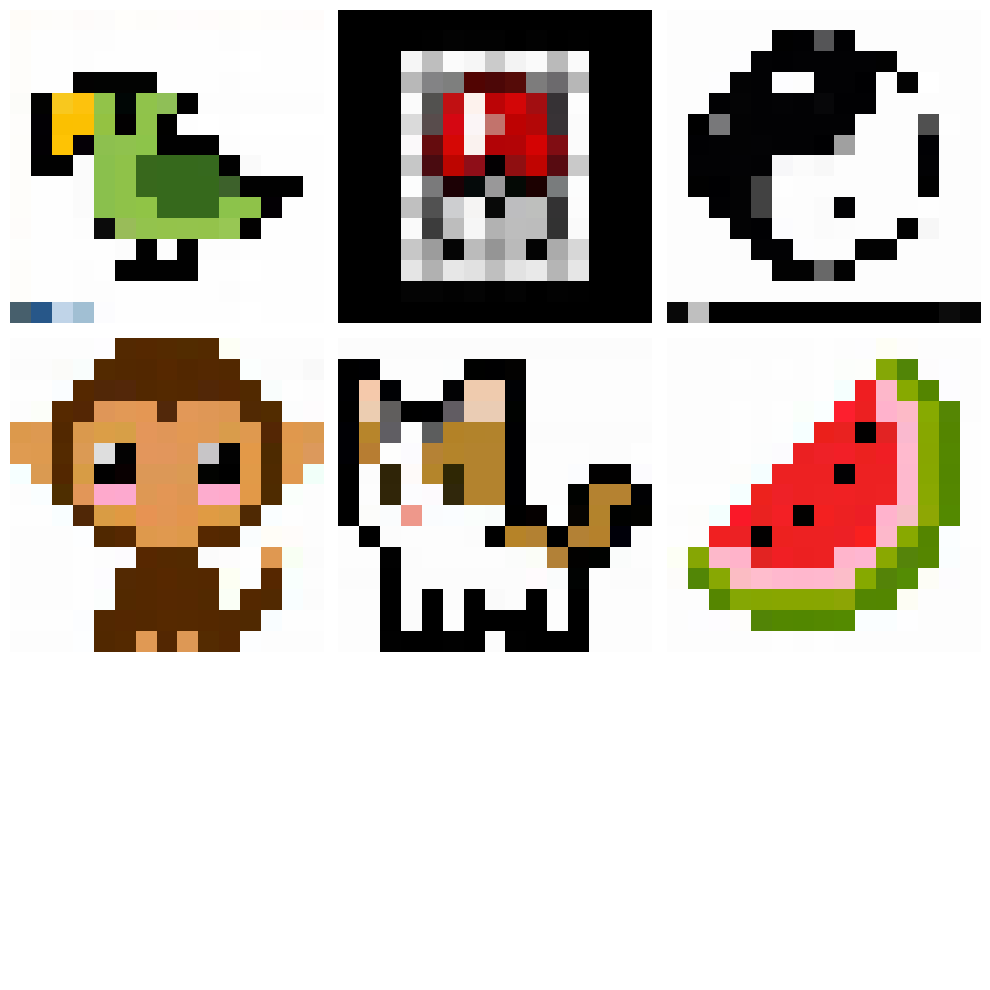

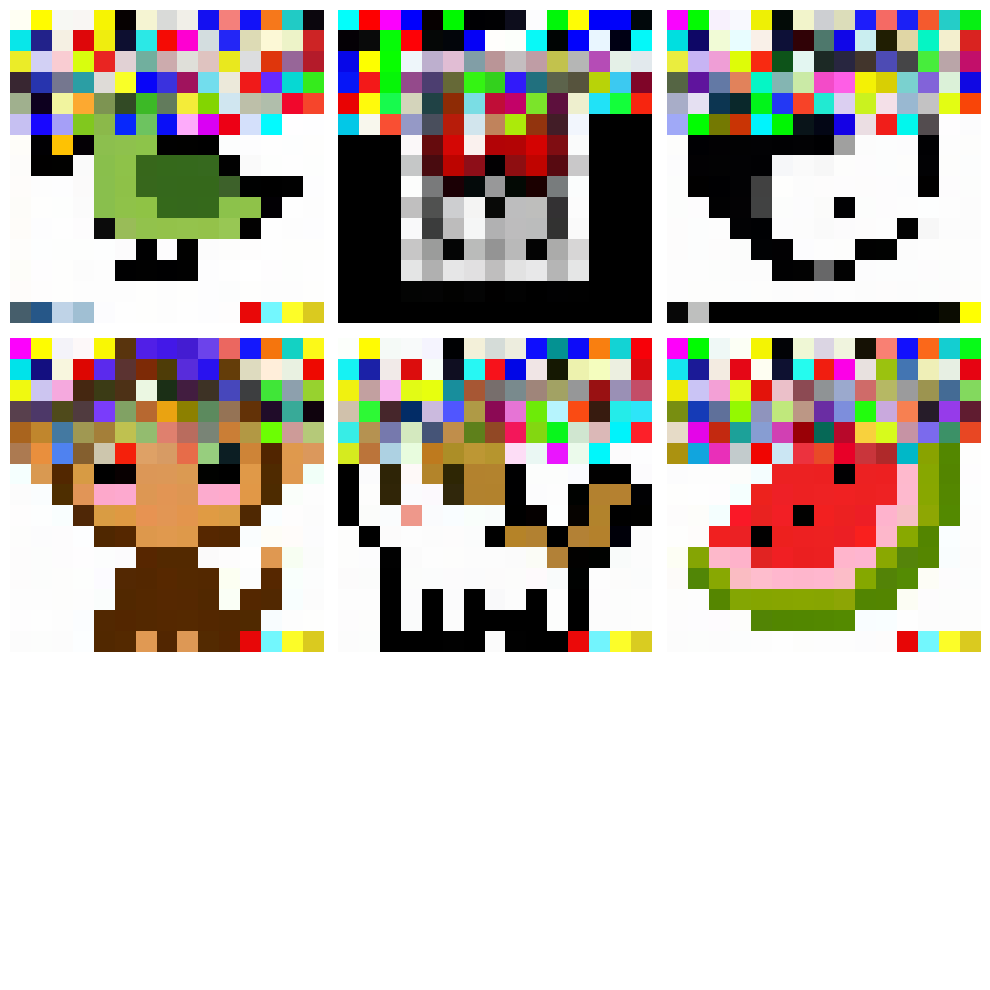

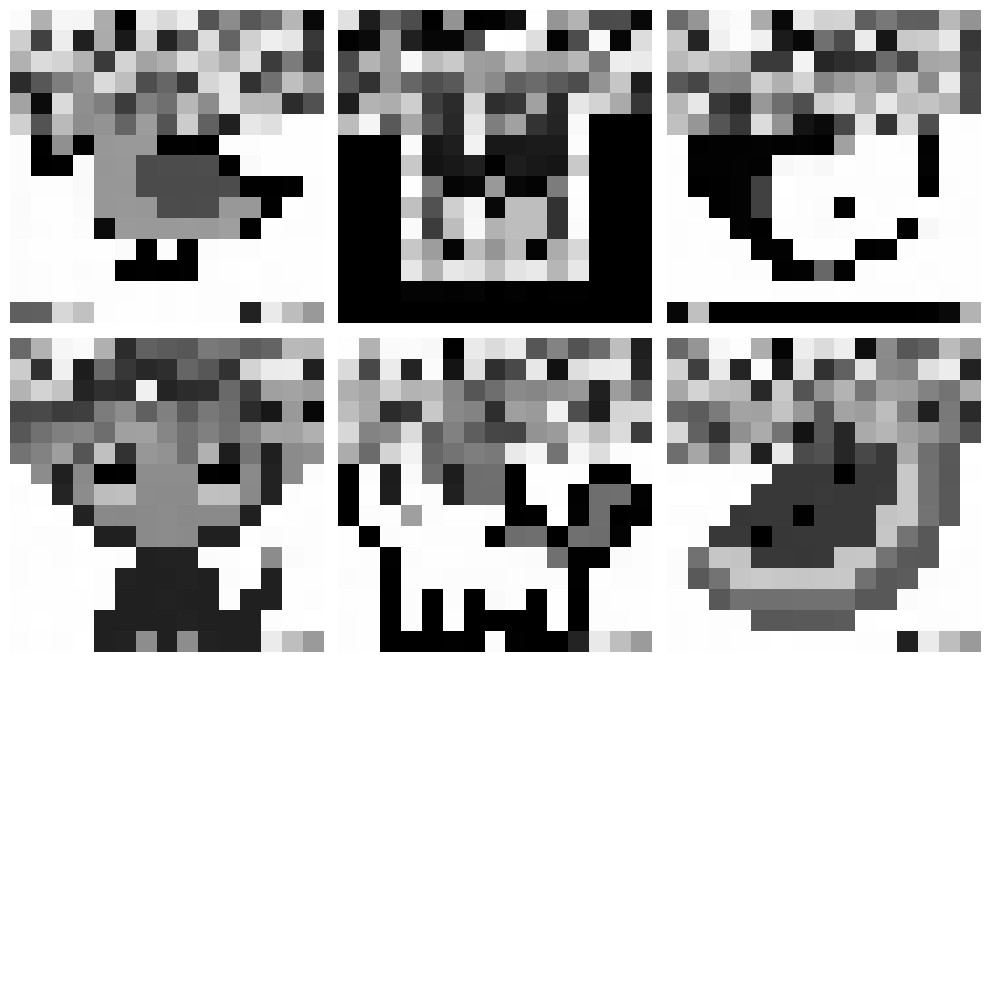

In [70]:
pca_imgs=pca.transform(flat_imgs)
pca_imgs = pca.reverse(pca_imgs)
pca_imgs =flatten.deflatten(pca_imgs)
pca_img_uint8 = pca_imgs.astype(np.uint8)

plot_images(images)
plot_images(pca_img_uint8)
plot_images(pca_img_uint8,type="gray")